# Reinforcement Learning

In this notebook we will implement simple, tabular Q-Learning to a simple problem solving example.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

## Load Environment Definition:

In [2]:
environment = pd.read_csv('../Data/Reward_and_state_transition.csv')
environment.head(15)

,state_no,state_action_no,violation_size,transmitter_size,metal_type,has_buffer,is_terminal,action,action_cost,prob_to_1,...,prob_to_39,prob_to_40,prob_to_41,prob_to_42,prob_to_43,prob_to_44,prob_to_45,prob_to_46,prob_to_47,prob_to_48
0,1,0,0,1,1,0,1,DN,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0,1,1,1,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,0,1,2,0,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,0,1,2,1,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,0,2,1,0,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,5,0,2,1,1,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,6,0,2,2,0,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,7,0,2,2,1,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,8,0,3,1,0,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,9,0,3,1,1,1,DN,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Initialize Q
Terminal states get initialized Q-value of const_terminal and the non terminal states get initialized Q-value of const_other.
A terminal state means that the receiver problem is solved (i.e., a good thing).

In [3]:
def init_Q(environment,const_terminal,const_other):
    n = environment.shape[0]
    Q =  np.full((n),const_other)
    terminals = environment.state_action_no[environment.is_terminal==1]
    Q[terminals] = const_terminal 
    return(Q);

In [20]:
Q = init_Q(environment,200.0,100.0)
print(Q)

[200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]


## Find Allowable Actions in State

In [21]:
def actions_in_state(state,env,Q_function):
    allowable_actions = env.loc[env.state_no == state,['action','state_action_no']]
    return(allowable_actions);

In [22]:
actions = actions_in_state(26,environment,Q)
print(actions)

                 action  state_action_no
41  Increse transmitter               41
42    switch metal type               42


## Retreive the Q-Values Relevant to State

In [23]:
def get_Q_values(Q_function,state_action_numbers):
    Q_values = np.take(Q_function, state_action_numbers)
    return(Q_values);

In [24]:
get_Q_values(Q,actions.state_action_no)

array([100., 100.])

## Extract Action Using Epsilon Greedy Policy

In [25]:
def epsilon_greedy(Q_values,allowable_actions,epsilon):
    if np.random.rand() <= epsilon:
        action = np.random.choice(allowable_actions,replace=False)
        return(action);
    else:
        max_ind = Q_values.argmax()
        action = allowable_actions.iloc[max_ind] 
        return(action);

In [26]:
print(epsilon_greedy(Q,actions.state_action_no,0))
print(epsilon_greedy(Q,actions.state_action_no,1))

41
41


## Execute the Action

action_realization generates the next state acording to the probability that is provided by the environment. 

In [27]:
def action_realization(environment,action,Q_function):
    cost = environment['action_cost'][action] # The direct cost of the action
    possible_next_states = np.array(environment.iloc[action,range(9,57)]) # The probabilities to transition to each of the available states
    non_zero_ind = np.where(possible_next_states>0)
    p_values=possible_next_states[non_zero_ind].tolist()
    selected = np.random.choice(len(p_values),replace=False,p=p_values)
    next_state = non_zero_ind[0][selected]+1
    ret_value = -cost + max(Q_function[environment.state_no==next_state])
    return(next_state,ret_value,cost);

In [28]:
next_state,ret_value,cost = action_realization(environment,41,Q)
print(next_state)
print(ret_value)
print(cost)

18
65.0
35


## Update the Q-Function

In [29]:
def update_Q(Q_function,entry,target_value,alpha):
    Q_function[entry] = (1-alpha)*Q_function[entry] + alpha*target_value
    return(Q_function);

In [30]:
Q = update_Q(Q,41,ret_value,0.01) 
print(Q)

[200.   200.   200.   200.   200.   200.   200.   200.   200.   200.
 200.   200.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.    99.65 100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.  ]


In [31]:
print(Q.dtype)

float64


## Run a Single Episode

In [32]:
def run_episode(environment,Q_function,epsilon,alpha,state):
    episode_ended = False
    total_cost = 0
    while (episode_ended == False):
        allowable_actions = actions_in_state(state,environment,Q_function)
        Q_values = get_Q_values(Q_function,allowable_actions['state_action_no'])
        action = epsilon_greedy(Q_values,allowable_actions['state_action_no'],epsilon)
        state,target_value,cost_action = action_realization(environment,action,Q_function)
        total_cost = total_cost + cost_action
        Q_function = update_Q(Q_function,action,target_value,alpha)
        if state<=12:
            episode_ended = True
    return(Q_function,total_cost);

In [34]:
def learn_and_analyze(environment,n_episodes,eps,analyze_frequecy,const_terminal = 100.0,const_other = 0,alph_init=0.2,alph_final=0.01):
    alph = alph_init
    alph_decay = (alph_final/alph_init)**(1/n_episodes) 
    Q = init_Q(environment,const_terminal,const_other)
    analysis_cost=0
    for s in range(13,49):
        Q,episode_cost = run_episode(environment,Q,epsilon=0,alpha=0,state=s)
        analysis_cost = analysis_cost + episode_cost
    analysis_cost = np.array(analysis_cost)
    for episode in range(0,n_episodes):
        alph = alph * alph_decay
        if episode%analyze_frequecy == 0:
            episode_analysis_cost=0
            for s in range(13,49):
                Q,episode_cost = run_episode(environment,Q,epsilon=0,alpha=0,state=s)
                episode_analysis_cost = episode_analysis_cost + episode_cost
            analysis_cost = np.append(arr=analysis_cost,values=episode_analysis_cost)
        else:
            s = np.random.choice(range(13,49),replace=False)
            Q,_ = run_episode(environment,Q,epsilon=eps,alpha=alph,state=s)
        if episode%500 == 0:
            print(Q)
    return(analysis_cost);
            

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200.]
[100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         122.18614202 124.06715205 127.11954798
  93.74471933  94.65988414 114.46319599 110.23355318 107.82355452
 100.55748736 100.3244689   78.82029009 101.24765073 100.22170234
  78.95662709  93.72045956 135.54182397 141.91602196 132.30666794
  92.93700401  96.20885834  91.42031276  80.56944135  79.74482225
  91.81907927  88.72163185  78.06101793 123.12829054 128.05430537
 122.93001393  98.92717092 103

[100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.          69.79396376  87.03935206  89.29848591
  80.78895217  84.84482342  86.77571118  51.4962574   79.10970135
  88.60389096  86.04316226  48.30626946  87.84476242  81.98227045
  60.95879989  89.49267531  58.715727    88.43748627  78.10246523
  84.02328667  88.76803626  86.6964297   64.84346688  76.122969
  82.84729603  48.4586754   78.50715971  76.10334793  81.21037794
  81.39631106  59.50734408  65.59869959  81.77324831  81.00228902
  88.28374026  25.40116616  83.1468096   78.34011857  69.54610635
  92.07451987  81.66684243  53.08767416  73.76163387  68.31807422
  88.82794915  60.5246801   78.33113223  73.38465537  90.98408474
  65.37205982  86.31059461  38.82013241  66.89731664  81.88988825
  82.07805784  82.24576591  76.16044474  58.65822436  72.90854517
  82.63550925  66.56889531  70.86741277  77.3238704   67.78454572
  69.39259902  64.27162075  

C:\Users\Public\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


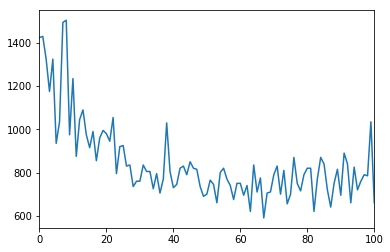

In [35]:
#np.random.seed(5)
analysis_cost = learn_and_analyze(environment,n_episodes = 5000,eps = 0.3,analyze_frequecy= 50,const_terminal = 100.0,const_other = 200.0)
#print(analysis_cost)
sns.tsplot(analysis_cost)
